In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import nibabel as nib
import pygalmesh
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('..')
import project

--------------------------------------------------------------------------

  Local host:   dv004
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')

In [4]:
examples = []
for case in emory4dct.cases:
    for fixed_phase in emory4dct.phases:
        moving_phase = (fixed_phase + 10) % 100
        
        anat_file = case.nifti_file(fixed_phase)
        mask_file = case.mask_file(fixed_phase, roi='lung_combined_mask')
        disp_file = case.disp_file(moving_phase, fixed_phase)
        mesh_file = case.mesh_file(fixed_phase, radius=20)
        
        example = (anat_file, mask_file, disp_file, mesh_file)
        examples.append(example)
        
len(examples)

100

In [5]:
class Dataset(torch.utils.data.Dataset):
     
    def __init__(self, examples, dtype, device):
        super().__init__()

        self.examples = examples
        self.dtype = dtype
        self.device = device

        self.cache = [None] * len(examples)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        if self.cache[idx] is None:
            self.cache[idx] = self.load_example(idx)
        return self.cache[idx]
    
    def load_example(self, idx):
        anat_file, mask_file, disp_file, mesh_file = self.examples[idx]    
        name = anat_file.stem
        
        # load data from NIFTI files
        anat = load_nii_file(anat_file)
        mask = load_nii_file(mask_file)
        disp = load_nii_file(disp_file)

        # get array spatial resolution
        resolution = anat.header.get_zooms()
        
        # load mesh from xdmf file
        mesh = load_mesh_file(mesh_file)
        
        # convert arrays to float32 tensors with shape (c,x,y,z)
        anat = torch.as_tensor(anat.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)
        mask = torch.as_tensor(mask.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)
        disp = torch.as_tensor(disp.get_fdata(), dtype=self.dtype, device=self.device).permute(3,0,1,2)

        return anat, mask, disp, resolution, mesh, name
    
def load_nii_file(nii_file):
    print(f'Loading {nii_file}... ', end='')
    nifti = nib.load(nii_file)
    print(nifti.header.get_data_shape())
    return nifti

def load_mesh_file(mesh_file):
    print(f'Loading {mesh_file}... ', end='')
    mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, str(mesh_file)) as f:
        f.read(mesh)
    print(mesh.num_vertices())
    return mesh

def collate_fn(batch):
    # we need a custom collate_fn bc mesh is not a tensor
    anat = torch.stack([ex[0] for ex in batch])
    mask = torch.stack([ex[1] for ex in batch])
    disp = torch.stack([ex[2] for ex in batch])
    resolution = [ex[3] for ex in batch]
    mesh = [ex[4] for ex in batch]
    name = [ex[5] for ex in batch]
    return anat, mask, disp, resolution, mesh, name

dataset = Dataset(examples, dtype=torch.float32, device='cuda')
example = dataset[0]

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T00_20.xdmf... 346


In [6]:
def my_tensor_repr(t):
    return f'Tensor(size={tuple(t.shape)}, μ={t.mean():.4f}, σ={t.std():.4f}, dtype={t.dtype}, device={t.device})'

torch.Tensor.__repr__ = my_tensor_repr

t = torch.randn(10, 10)
t[0,0] = np.nan
t

Tensor(size=(10, 10), μ=nan, σ=nan, dtype=torch.float32, device=cpu)

In [7]:
class ConvUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.norm = torch.nn.BatchNorm3d(in_channels)
        self.conv = torch.nn.Conv3d(in_channels, out_channels, kernel_size, padding='same', padding_mode='replicate')
        self.relu = torch.nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class ConvBlock(torch.nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size, num_conv_layers, hidden_channels=None):
        super().__init__()
        
        if not hidden_channels:
            hidden_channels = out_channels
        elif num_conv_layers < 2:
            print('Warning: hidden_channels argument only used if num_conv_layers >= 2')

        for i in range(num_conv_layers):
            layer = ConvUnit(
                in_channels=(hidden_channels if i > 0 else in_channels),
                out_channels=(hidden_channels if i < num_conv_layers - 1 else out_channels),
                kernel_size=kernel_size
            )
            self.add_module(f'conv_unit{i}', layer)
            

class Upsample(torch.nn.Module):
    
    def __init__(self, mode):
        super().__init__()
        self.mode = mode
        
    def __repr__(self):
        return f'{type(self).__name__}(mode={self.mode})'
        
    def forward(self, x, size):
        return F.interpolate(x, size=size, mode=self.mode)


class EncoderBlock(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        apply_pooling=True,
        pool_kernel_size=2,
        pool_type='max'
    ):
        super().__init__()
        assert pool_type in {'max', 'avg'}

        if apply_pooling:
            if pool_type == 'max':
                self.pooling = torch.nn.MaxPool3d(kernel_size=pool_kernel_size)
            elif pool_type == 'avg':
                self.pooling = torch.nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None
            
        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels
        )
        
    def forward(self, x):
        if self.pooling:
            x = self.pooling(x)
        x = self.conv_block(x)
        return x


class DecoderBlock(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        
        upsampling_mode='nearest'
    ):
        super().__init__()

        self.upsampling = Upsample(mode=upsampling_mode)

        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels,
        )

    def forward(self, x, encoder_feats):
        x = self.upsampling(x, size=encoder_feats.shape[2:])
        x = torch.cat([encoder_feats, x], dim=1)
        x = self.conv_block(x)
        return x


In [23]:
class UNet3D(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        conv_channels,
        num_levels,
        pool_kernel_size=2,
        pool_type='max',
        upsampling_mode='trilinear',
    ):
        super().__init__()
        assert num_levels > 0
        
        curr_channels = in_channels
        next_channels = conv_channels
        
        self.encoder = torch.nn.Sequential()
        for i in range(num_levels):
        
            encoder_block = EncoderBlock(
                in_channels=curr_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                apply_pooling=(i > 0),
                pool_kernel_size=pool_kernel_size,
                pool_type=pool_type
            )
            self.encoder.add_module(f'level{i}', encoder_block)

            curr_channels = next_channels
            next_channels = curr_channels * 2
        
        next_channels = curr_channels // 2
        
        self.decoder = torch.nn.Sequential()
        for i in reversed(range(num_levels - 1)):

            decoder_block = DecoderBlock(
                in_channels=curr_channels + next_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                upsampling_mode=upsampling_mode
            )
            self.decoder.add_module(f'level{i}', decoder_block)
            
            curr_channels = next_channels
            next_channels = curr_channels // 2
        
        self.final_conv = torch.nn.Conv3d(curr_channels, out_channels, kernel_size=1)

    def forward(self, x):
        
        # encoder part
        encoder_feats = []
        for i, encoder in enumerate(self.encoder):
            x = encoder(x)
            encoder_feats.append(x)
        
        # reverse encoder features to align with decoder
        encoder_feats = encoder_feats[::-1]
    
        # decoder part
        for i, decoder in enumerate(self.decoder):
            x = decoder(x, encoder_feats[i+1])

        return self.final_conv(x)


model = UNet3D(in_channels=1, out_channels=1, conv_kernel_size=3, num_conv_layers=2, conv_channels=4, num_levels=3)
model.cuda()

UNet3D(
  (encoder): Sequential(
    (level0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (conv_unit1): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (level1): EncoderBlock(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [77]:
class LinearElasticPDE(torch_fenics.FEniCSModule):
    
    def __init__(self, mesh):
        super().__init__()
        self.mesh = mesh
        self.S = fe.FunctionSpace(mesh, 'P', 1)
        self.V = fe.VectorFunctionSpace(mesh, 'P', 1)
        
    def __repr__(self):
        return f'{type(self).__name__}({self.mesh})'
        
    def input_templates(self):
        scalar_f = fa.Function(self.S)
        vector_f = fa.Function(self.V)
        return vector_f, scalar_f, scalar_f
    
    def solve(self, u_true, mu, rho):

        # define physical parameters
        g  = 9.8e-3 # gravitational acc (mm/s^2)
        nu = 0.4    # Poisson's ratio (unitless)

        # Lame's first parameter (Pa)
        lam = 2*mu*nu/(1 - 2*nu)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.V, u_true, 'on_boundary')

        # body force and traction
        b = fe.as_vector([0, rho*g, 0])
        t = fa.Constant([0, 0, 0])

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam*fe.div(u)*I + 2*mu*epsilon(u)

        # weak formulation
        u = fe.TrialFunction(self.V)
        v = fe.TestFunction(self.V)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v)*fe.dx + fe.dot(t, v)*fe.dx
        
        # store for debugging purposes
        self.a = a
        self.L = L
        self.u_bc = u_bc

        u_pred = fa.Function(self.V)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred


In [78]:
def as_xarray(a, dims=None, coords=None, name=None):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if dims is None:
        dims = [f'dim{i}' for i in range(a.ndim)]
    if coords is None:
        coords = {d: np.arange(a.shape[i]) for i, d in enumerate(dims)}
    return xr.DataArray(a, dims=dims, coords=coords, name=name)

#project.visual.view(as_xarray(output_image[0], dims=['component', 'x', 'y', 'z']), cmap='seismic')

case1_T50.nii
Tensor(size=(1, 256, 256, 94), μ=-476.8201, σ=479.7949, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


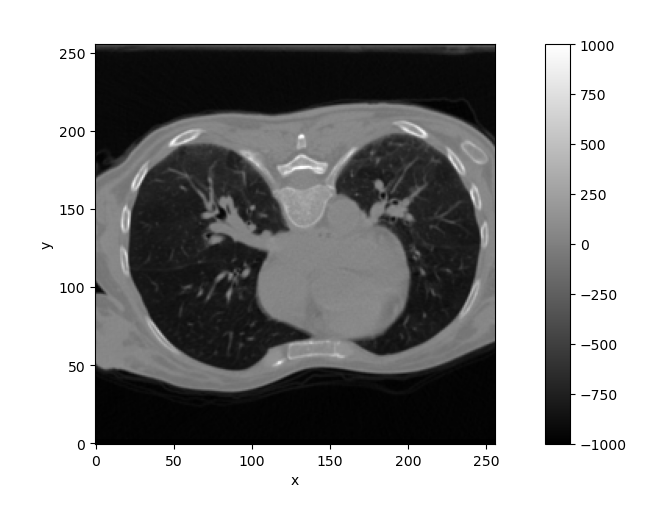

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [79]:
anat_image, mask, u_image, resolution, mesh, name = dataset[5]
print(name)
print(anat_image)
project.visual.view(as_xarray(anat_image, dims=['channel', 'x', 'y', 'z'], name='CT'))

Tensor(size=(1, 256, 256, 94), μ=2015.0511, σ=92737.3359, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


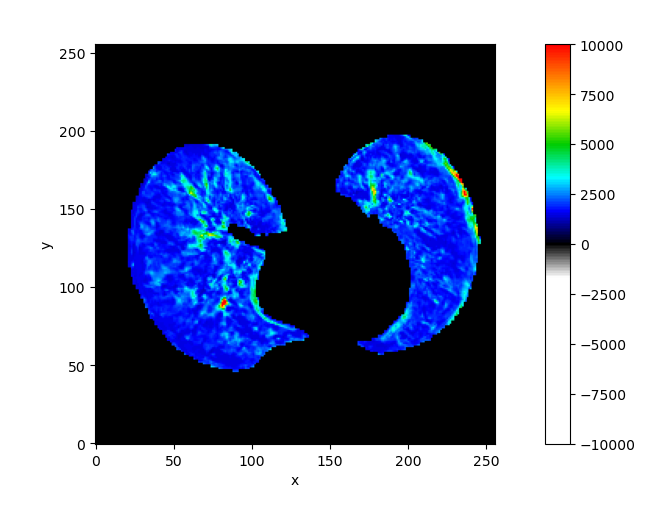

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [81]:
mu_image = model.forward(anat_image.unsqueeze(0))[0]
mu_image = 1000 * torch.exp(mu_image)
print(mu_image)

project.visual.view(as_xarray(mu_image * mask, dims=['channel', 'x', 'y', 'z'], name='mu'), vmax=1e4)

Tensor(size=(1, 256, 256, 94), μ=523.1798, σ=479.7949, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


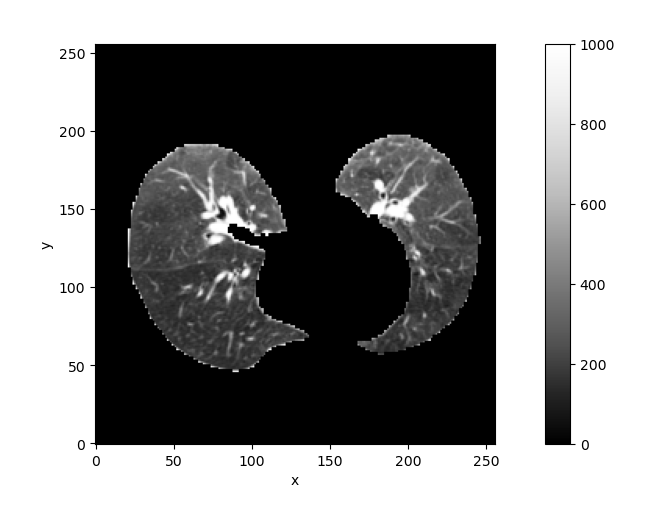

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [83]:
rho_image = 1000*(1 + anat_image/1000)
print(rho_image)

project.visual.view(as_xarray(rho_image * mask, dims=['channel', 'x', 'y', 'z']), cmap='Greys_r', vmin=0, vmax=1000)

In [84]:
pde = LinearElasticPDE(mesh)

u_dofs = project.interpolate.image_to_dofs(u_image, resolution, pde.V).cpu()
u_dofs

Tensor(size=(305, 3), μ=0.0218, σ=0.1435, dtype=torch.float64, device=cpu)

In [85]:
mu_dofs = project.interpolate.image_to_dofs(mu_image, resolution, pde.S).cpu()
mu_dofs

Tensor(size=(305,), μ=2227.8683, σ=913.3561, dtype=torch.float64, device=cpu)

In [86]:
rho_dofs = project.interpolate.image_to_dofs(rho_image, resolution, pde.S).cpu()
rho_dofs

Tensor(size=(305,), μ=534.9120, σ=225.6425, dtype=torch.float64, device=cpu)

In [87]:
u_sim_dofs = pde.forward(
    u_dofs.unsqueeze(0),
    mu_dofs.unsqueeze(0),
    rho_dofs.unsqueeze(0),
)[0]

u_sim_dofs

Tensor(size=(305, 3), μ=nan, σ=nan, dtype=torch.float64, device=cpu)

In [88]:
u_sim_dofs.detach().cpu().numpy()

array([[ 1.88707318e-02,  1.21554709e-03,  6.10755058e-03],
       [ 4.09616455e-02, -9.69666895e-03,  8.41941405e-03],
       [ 6.66320324e-02, -1.72970276e-02,  1.76098831e-02],
       [-1.57220364e-02,  2.17953622e-02,  6.66179135e-03],
       [ 2.98295394e-02, -5.02180448e-03, -1.75969012e-03],
       [ 7.59684201e-03, -8.02559778e-03, -9.72635765e-03],
       [-1.10156108e-02, -7.00335251e-03,  1.10651983e-03],
       [-4.07633289e-02,  1.31644690e-01,  6.22512947e-02],
       [-1.33350836e-02,  3.98309343e-02, -3.16665531e-03],
       [ 3.19923135e-03,  1.01728626e-02, -3.88142164e-03],
       [-2.19789091e-02, -2.94386572e-03,  1.35582360e-02],
       [-9.49821249e-02,  4.49146889e-02, -1.16072325e-02],
       [-1.62011515e-02,  1.02134822e-02, -6.11155573e-03],
       [-8.42865678e-03,  2.15710117e-01,  8.73484077e-02],
       [ 3.47145848e-03,  2.39214159e-01,  5.60443358e-02],
       [-1.61245838e-03, -2.97566643e-03, -1.31805679e-02],
       [ 9.04644281e-03,  7.98690990e-02

In [94]:
K = fa.assemble(pde.a).array()
K

array([[ 77102.03958337, -14392.61775331, -62693.76754758, ...,
             0.        ,      0.        ,      0.        ],
       [-14392.61775331,  81098.10356962,  53651.59072332, ...,
             0.        ,      0.        ,      0.        ],
       [-62693.76754758,  53651.59072332, 177229.62894256, ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [98]:
K[-3:,-3:]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [105]:
import dolfin

help(dolfin.MeshQuality)

Help on class MeshQuality in module dolfin.cpp.mesh:

class MeshQuality(pybind11_builtins.pybind11_object)
 |  DOLFIN MeshQuality class
 |  
 |  Method resolution order:
 |      MeshQuality
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  aspect_ratio_gamma(...) from builtins.PyCapsule
 |      aspect_ratio_gamma(arg0: dolfin.cpp.mesh.Mesh) -> dolfin.cpp.mesh.MeshFunctionDouble
 |  
 |  dihedral_angles_matplotlib_histogram(...) from builtins.PyCapsule
 |      dihedral_angles_matplotlib_histogram(arg0: dolfin.cpp.mesh.Mesh, arg1: int) -> str
 |  
 |  dihedral_angles_min_max(...) from builtins.PyCapsule
 |      dihedral_angles_min_max(arg0: dolfin.cpp.mesh.Mesh) -> tuple[float, float]
 |  
 |  radius_ratio_hi

In [106]:
dolfin.MeshQuality.radius_ratio_min_max(mesh)

(0.23618429715702463, 0.9936843361516599)

In [114]:
mesh.topology().dim()

3

In [126]:
num_vertices = mesh.num_vertices()

print(f'Total vertices: {num_vertices}')

mesh.init(0, 3)
vertex_to_cell = mesh.topology()(0, 3)

min_edges = 1e9
max_edges = -1

for i, v in enumerate(range(num_vertices)):
    n_edges = len(vertex_to_cell(v))
    max_edges = max(n_edges, max_edges)
    min_edges = min(n_edges, min_edges)
    if n_edges == 0:
        print(i)
    
min_edges, max_edges 

Total vertices: 1818
263


(0, 60)

In [123]:
mesh = dolfin.refine(mesh)

In [125]:
mesh

In [89]:
def compute_loss(u_pred, u_true, eps=1e-8):
    u_diff = (u_pred - u_true)
    u_diff_norm2 = (u_diff**2).sum(axis=-1)
    u_true_norm2 = (u_true**2).sum(axis=-1) + eps
    return torch.mean(u_diff_norm2 / u_true_norm2)

compute_loss(u_sim_dofs, u_dofs)

/var/tmp/ipykernel_67350/687170996.py:2: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  return f'Tensor(size={tuple(t.shape)}, μ={t.mean():.4f}, σ={t.std():.4f}, dtype={t.dtype}, device={t.device})'


Tensor(size=(), μ=nan, σ=nan, dtype=torch.float64, device=cpu)

In [47]:
%%time

def train(dataset, model, batch_size, n_epochs, learning_rate):
    
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=False, collate_fn=collate_fn
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1} / {n_epochs}')

        for i, batch in enumerate(data_loader):
            anat_image, mask, u_image, res, mesh, name = batch
            print(name, end=' ')
        
            mu_image = model.forward(anat_image)

            mu_image = 1000*torch.exp(mu_image)
            rho_image = 1000*(1 + anat_image/1000)
            
            loss = 0
            for j in range(batch_size):          
                pde = LinearElasticPDE(mesh[j])
    
                u_dofs = project.interpolate.image_to_dofs(u_image[j], res[j], pde.V).cpu()
                mu_dofs = project.interpolate.image_to_dofs(mu_image[j], res[j], pde.S).cpu()
                rho_dofs = project.interpolate.image_to_dofs(rho_image[j], res[j], pde.S).cpu()
                
                u_sim_dofs = pde.forward(
                    u_dofs.unsqueeze(0),
                    mu_dofs.unsqueeze(0),
                    rho_dofs.unsqueeze(0),
                )[0]
    
                loss_j = compute_loss(u_sim_dofs, u_dofs)
                if loss_j.isnan():
                    raise RuntimeError(name)
                
                loss = loss + loss_j

            loss = loss / batch_size
            print(f'{loss.item():.4f}')
            
            loss.backward()
            optimizer.step()

train(dataset, model, batch_size=1, n_epochs=1, learning_rate=0)

Epoch 1 / 1
['case1_T00.nii'] 18.6803
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T20_T10.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T10_20.xdmf... 328
['case1_T10.nii'] 27.7629
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T30_T20.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T20_20.xdmf... 314
['case1_T20.nii'] 1.5511
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrFi

RuntimeError: ['case1_T50.nii']

In [ ]:
mu_image = model.forward(anat_image.unsqueeze(0))[0]
mu_image = 1000 * torch.exp(mu_image)

project.visual.view(as_xarray(mu_image, dims=['channel', 'x', 'y', 'z']))